In [31]:
import torch

import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision
import matplotlib.pyplot as plt

from network import *
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [32]:
bs=100
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [33]:
 #build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator().to(device)
D = Discriminator().to(device)

C:\Users\admin\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [34]:
# loss
criterion = nn.BCELoss() 
# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [35]:
def D_train(x):
    
    D.zero_grad()
    bs = x.shape[0]  
    # train discriminator on real
    x_real, y_real = x, torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim,1,1).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [36]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()
    bs = x.shape[0]
    z = Variable(torch.randn(bs, z_dim,1,1).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item(),G_output.detach()


C:\Users\admin\anaconda3\lib\site-packages\torch\nn\modules\loss.py:516: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


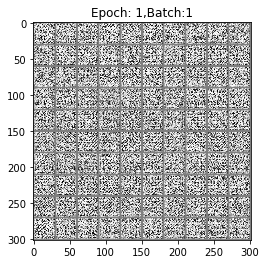

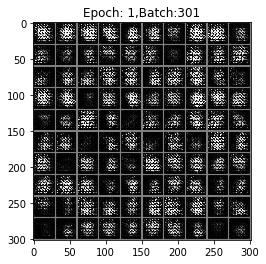

[1/20]: loss_d: 0.045, loss_g: 5.769


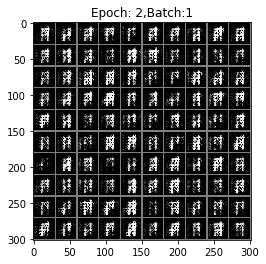

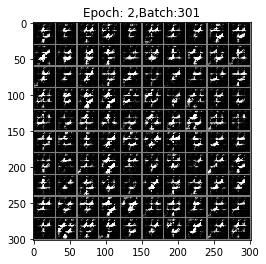

[2/20]: loss_d: 0.033, loss_g: 6.281


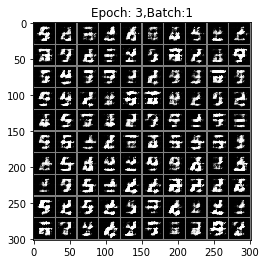

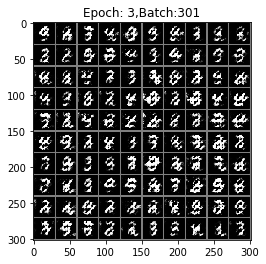

[3/20]: loss_d: 0.045, loss_g: 6.139


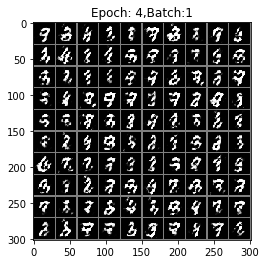

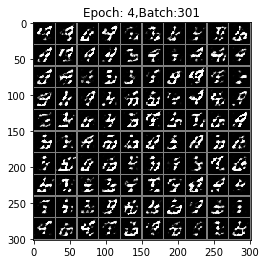

[4/20]: loss_d: 0.047, loss_g: 6.053


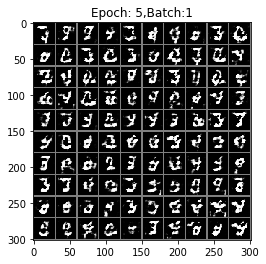

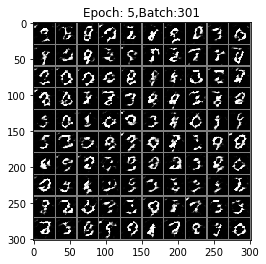

[5/20]: loss_d: 0.062, loss_g: 5.854


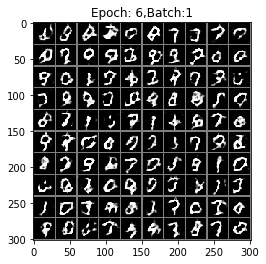

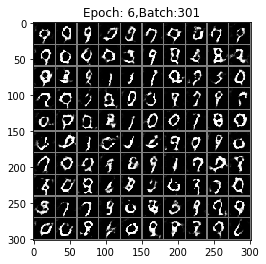

[6/20]: loss_d: 0.092, loss_g: 5.521


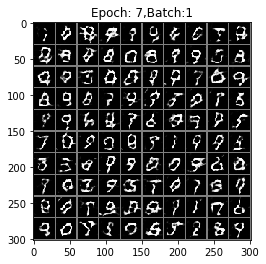

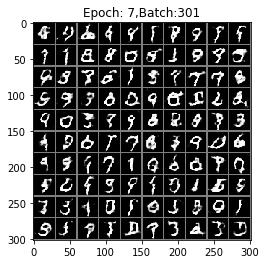

[7/20]: loss_d: 0.126, loss_g: 5.213


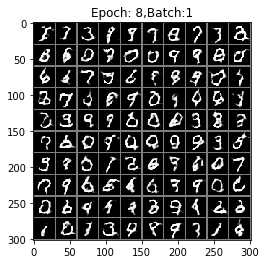

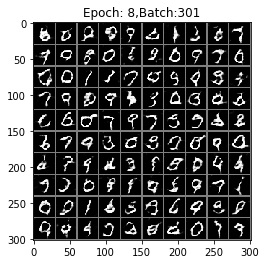

[8/20]: loss_d: 0.160, loss_g: 4.930


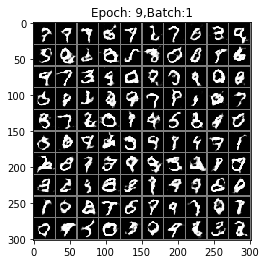

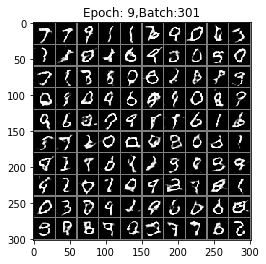

[9/20]: loss_d: 0.185, loss_g: 4.675


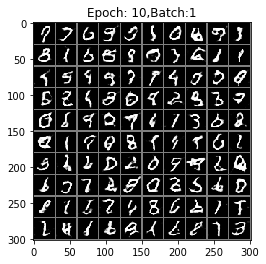

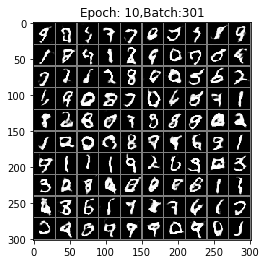

[10/20]: loss_d: 0.209, loss_g: 4.466


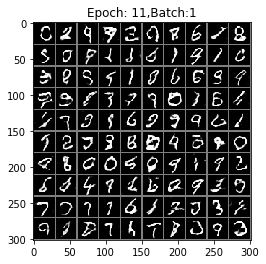

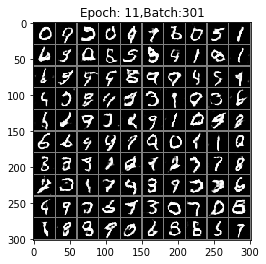

[11/20]: loss_d: 0.229, loss_g: 4.282


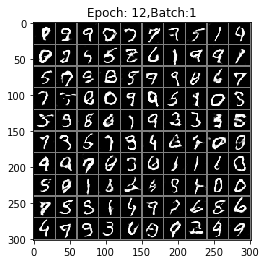

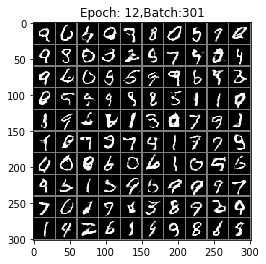

[12/20]: loss_d: 0.249, loss_g: 4.130


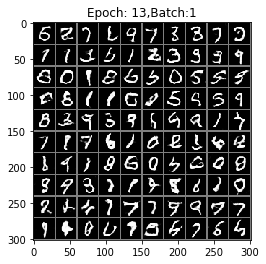

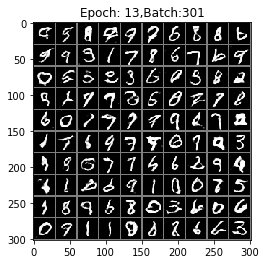

[13/20]: loss_d: 0.267, loss_g: 3.998


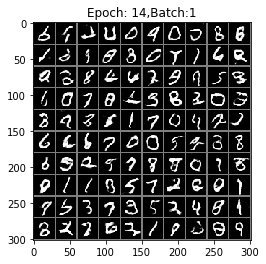

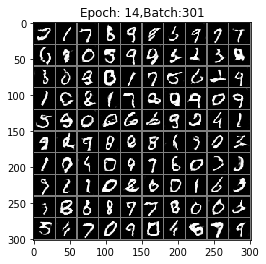

[14/20]: loss_d: 0.281, loss_g: 3.879


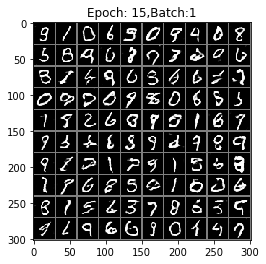

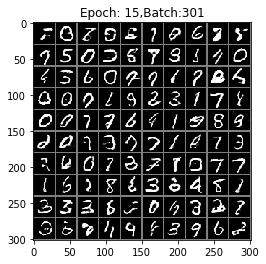

[15/20]: loss_d: 0.294, loss_g: 3.778


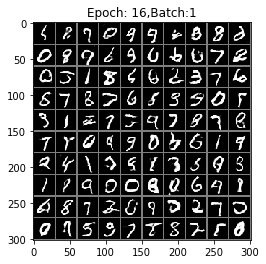

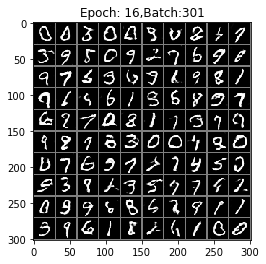

[16/20]: loss_d: 0.304, loss_g: 3.689


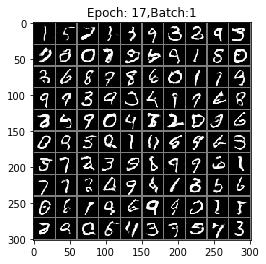

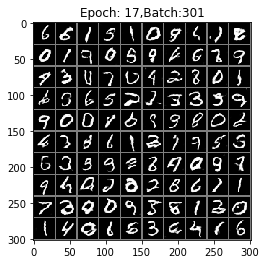

[17/20]: loss_d: 0.313, loss_g: 3.611


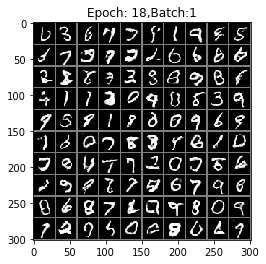

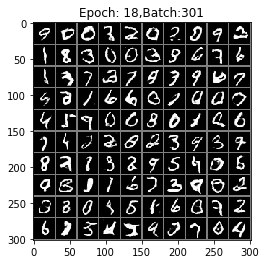

[18/20]: loss_d: 0.322, loss_g: 3.541


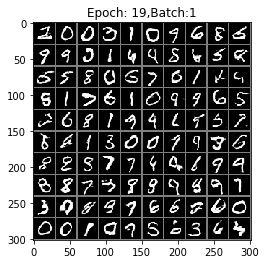

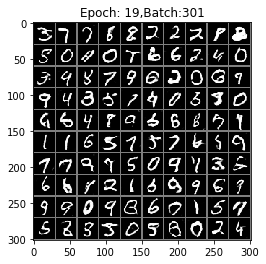

[19/20]: loss_d: 0.329, loss_g: 3.478


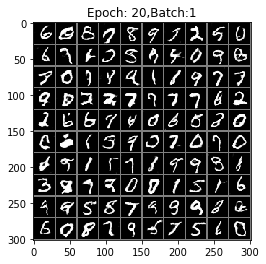

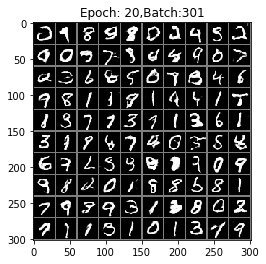

[20/20]: loss_d: 0.336, loss_g: 3.425


In [37]:
n_epoch = 20
D_losses, G_losses = [], []

for epoch in range(1, n_epoch+1):           
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_loss,gen_data=G_train(x)
        G_losses.append(G_loss)
        if batch_idx %300 ==0:
            gen_data=gen_data.view(100,1,28,28)
            grid_img = torchvision.utils.make_grid(gen_data, nrow=10)
            plt.figure()
            plt.title(f"Epoch: {epoch},Batch:{batch_idx+1}")
            plt.imshow(grid_img.cpu().permute(1,2,0)*0.5+0.5)
            plt.show()

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

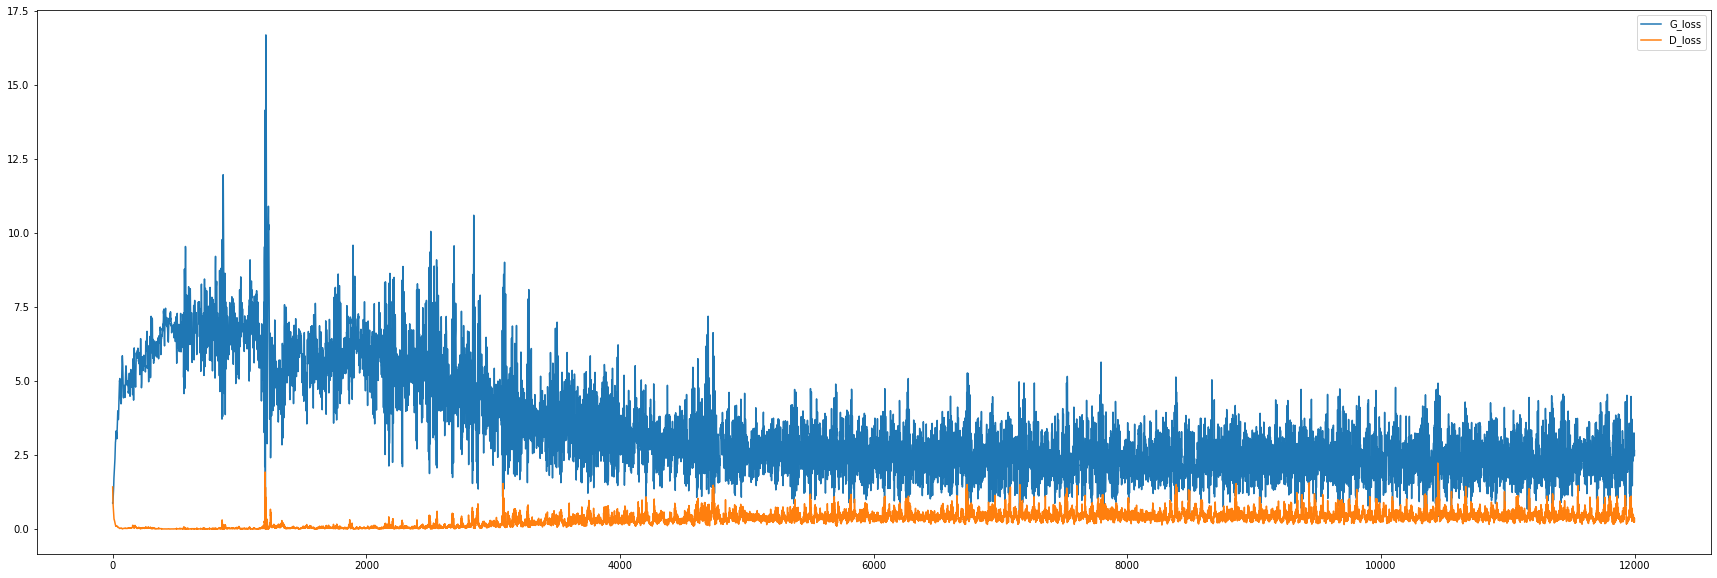

In [38]:
plt.figure(figsize=(30,10))
plt.plot(G_losses,label='G_loss')
plt.plot(D_losses,label='D_loss')
plt.legend()
